# LSTM with time until failure

### Imports

In [26]:
import os
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

### Getting files from file directory

In [27]:
files = [file for file in os.listdir('../../Processed Sensors')]
files.sort()
read_files = []
for file in files:
    read_files.append(pd.read_csv('../../Processed Sensors/' + file))

### Finding mutual sensors

In [28]:
cols_file = [read_files[i].columns.tolist() for i in range(len(read_files))]
common_els = reduce(set.intersection, (set(item) for item in cols_file))
common_els = list(common_els)
read_files = [read_files[i][common_els] for i in range(len(read_files))]

### Reading the equipment downtime which we use for label generation

In [29]:
downtimeNew = pd.read_excel('../../Raw Data/Equipment downtime data (202310).xlsx')
downtimeNew['FaultDate'] = pd.to_datetime(downtimeNew['FaultDate'], errors='coerce').dt.date
downtimeNew['FaultTime'] = downtimeNew['FaultTime'].apply(lambda x: x.strftime('%H:%M:%S') if len(str(x)) > 8 else x)
downtimeNew = downtimeNew.dropna(subset=['FaultDate', 'FaultTime'])
pattern_new = downtimeNew.iloc[:, :14]
pattern_new = pattern_new.drop(['ID', 'DutyOfficer', 'Manager email address'], axis=1)
pattern_new['FaultDateTime'] = pd.to_datetime(pattern_new['FaultDate'].astype(str) + ' ' + pattern_new['FaultTime'].astype(str))
pattern_new.drop(['FaultDate', 'FaultTime'], axis=1, inplace=True)
pattern_new.sort_values(by=['FaultDateTime'], inplace=True)
pattern_new = pattern_new.drop(['LogEntry', 'DutyOfficer comments', 'Managerscomments', 'FaultRepair', 'FaultDescription', 'Group', 'Downtime'], axis=1)
pattern_new['Equipment'] = pattern_new['Equipment'].str.lower()
pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '')
pattern_new = pattern_new[pattern_new['Equipment'] == 'ion source']

/var/folders/nl/8bkjfnbd2k53t1p3_gjy6k9h0000gn/T/ipykernel_25154/573615324.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '')


### Drawing out Ion Source fails

In [30]:
userruns = ['18/04', '19/01', '19/02', '19/03', '20/01', '20/02', '20/03', '21/01', '21/02', '22/01', '22/02', '22/03', '22/04', '22/05', '23/01', '23/02', '23/03']
isrcFailRuns = [pattern_new[pattern_new['User Run'] == ur] for ur in userruns]

for i in range(len(isrcFailRuns)):
    isrcFailRuns[i].reset_index(drop=True, inplace=True) 
    for j in range(len(isrcFailRuns[i])-1):
        if isrcFailRuns[i]['FaultDateTime'][j+1] - isrcFailRuns[i]['FaultDateTime'][j] < pd.Timedelta('1 hour'):
            isrcFailRuns[i].loc[j+1, 'FaultDateTime'] = isrcFailRuns[i]['FaultDateTime'][j]
    isrcFailRuns[i] = isrcFailRuns[i].drop_duplicates(subset=['FaultDateTime'], keep='first')
    isrcFailRuns[i].reset_index(drop=True, inplace=True)

for i in range(len(read_files)):
    read_files[i]['Label'] = -1
    read_files[i]['Time'] = pd.to_datetime(read_files[i]['Time'], format='%d/%m/%Y, %H:%M:%S')
    for j in range(read_files[i].shape[0]-1):
        for el in isrcFailRuns[i]['FaultDateTime']:
            if read_files[i]['Time'][j] <= el < read_files[i]['Time'][j+1]:
                read_files[i].loc[j, 'Label'] = 0   #['Label'][j] = 1
                break

KeyboardInterrupt: 

### Labels generation, in terms of time until failure

Define function to find the minutes until fail

In [ ]:
import numpy as np

def convert_to_time_until_zero(data):
    data_array = np.array(data)

    non_negative_indices = np.where(data_array >= 0)[0]

    converted_data = np.zeros_like(data_array)

    nni = 0

    for i in range(len(data_array)):
        if data_array[i] == -1:
            if nni == len(non_negative_indices):
                converted_data[i] = -1
            else:
                converted_data[i] = non_negative_indices[nni] - i
        else:
            converted_data[i] = data_array[i]
            nni += 1

    return converted_data

# Example usage
data = [-1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1]
converted_data = convert_to_time_until_zero(data)
print(converted_data)


[ 1  0  5  4  3  2  1  0  5  4  3  2  1  0 -1 -1]


Implement the function in the dataframes

In [ ]:
for i in range(len(read_files)):
    read_files[i]['Label'] = convert_to_time_until_zero(read_files[i]['Label'])

### Add ion source count, counting how many times maintenance occured

Define function

In [ ]:
def convert_list(list1, ct):
    list2 = []
    for i in range(len(list1)):
        list2.append(ct)
        if list1[i] == 0:
            ct+=1
    return list2, ct

# Example usage
ct = 1
list1 = [5, 4, 3, 2, 1, 0, 3, 2, 1, 0]
converted_list, ct = convert_list(list1, ct)
print(converted_list)
print(ct)

[1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
3


Implement function

In [ ]:
ct = 1
for i in range(len(read_files)):
    read_files[i]['Maintenance'], ct = convert_list(read_files[i]['Label'], ct)
    ct+=1

Drop all readings that dont anticipate a fail

In [ ]:
# Remove entries with -1 as label
for i in range(len(read_files)):
    read_files[i] = read_files[i][read_files[i]['Label'] != -1]

### Finding best sensors

In [11]:
### To DO, code below is replacement
kbSensors = [
    'Time',
    'Maintenance',
    'irfq::mag:read_volts',
    'irfq::gas:back_press',
    'irfq::mag:read_current',
    'irfq::arc_dc:read_current',
    'irfq::arc_pulser_on:sta',
    'irfq::gas:read_press',
    'irfq::ion_source:sta',
    'irfq::arc_dc:set_current',
    'irfq::h2_gas:read_flow',
    'irfq::arc_ac:read_current',
    'irfq::gas:on',
    'irfq::arc_remote:sta',
    'irfq::arc_dc_on:sta',
    'irfq::arc_dc:on',
    'irfq::arc_dc:read_volts',
    'irfq::platform:read_volts',
    'irfq::isrce_line:read_press',
    'irfq::ext:set_volts',
    'irfq::mag_on:sta',
    'irfq::arc_ac:set_current',
    'irfq::ext:read_current',
    'irfq::arc_pulser_intlk:sta',
    'irfq::ext:read_volts',
    'irfq::gas:set_press',
    'Label'
]

cols = [
    'irfq::mag:read_volts',
    'irfq::gas:back_press',
    'irfq::mag:read_current',
    'irfq::arc_dc:read_current',
    'irfq::arc_pulser_on:sta',
    'irfq::gas:read_press',
    'irfq::ion_source:sta',
    'irfq::arc_dc:set_current',
    'irfq::h2_gas:read_flow',
    'irfq::arc_ac:read_current',
    'irfq::gas:on',
    'irfq::arc_remote:sta',
    'irfq::arc_dc_on:sta',
    'irfq::arc_dc:on',
    'irfq::arc_dc:read_volts',
    'irfq::platform:read_volts',
    'irfq::isrce_line:read_press',
    'irfq::ext:set_volts',
    'irfq::mag_on:sta',
    'irfq::arc_ac:set_current',
    'irfq::ext:read_current',
    'irfq::arc_pulser_intlk:sta',
    'irfq::ext:read_volts',
    'irfq::gas:set_press'
]

### Setting sensors used

In [12]:
rfNew = read_files.copy()
rfNew = [rfNew[i][kbSensors] for i in range(len(rfNew))]

### Splitting the data

In [13]:
df_train = pd.concat(rfNew[:14])
df_test = pd.concat(rfNew[14:])

In [14]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

### Preparing the data for LSTM

In [15]:
def gen_train(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array = []
    if seq_length > num_elements:
        print(id_df)
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)
    # for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
    #     yield data_array[start:stop, :]

def gen_target(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

df_train[cols] = min_max_scaler.fit_transform(df_train[cols])

sequence_length = 60

X_train = np.concatenate(list(list(gen_train(df_train[df_train['Maintenance'] == mt], sequence_length, cols)) for mt in df_train['Maintenance'].unique()))
y_train = np.concatenate(list(list(gen_target(df_train[df_train['Maintenance'] == mt], sequence_length, 'Label')) for mt in df_train['Maintenance'].unique()))

In [16]:
nb_features = X_train.shape[2]
nb_out = 1

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out, activation='relu'))
model.add(Activation('relu'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 256)           287744    
                                                                 
 batch_normalization (Batch  (None, 60, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 60, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [17]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1
                    ,callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/20
10021/10021 [==============================] - 1603s 160ms/step - loss: 32821374.0000 - mse: 32821374.0000 - val_loss: 25850248.0000 - val_mse: 25850248.0000
Epoch 2/20
10021/10021 [==============================] - 1676s 167ms/step - loss: 26440186.0000 - mse: 26440186.0000 - val_loss: 24297308.0000 - val_mse: 24297308.0000
Epoch 3/20
10021/10021 [==============================] - 1664s 166ms/step - loss: 22166756.0000 - mse: 22166756.0000 - val_loss: 24738210.0000 - val_mse: 24738210.0000
Epoch 4/20
10021/10021 [==============================] - 1619s 162ms/step - loss: 19088604.0000 - mse: 19088604.0000 - val_loss: 24175776.0000 - val_mse: 24175776.0000
Epoch 5/20
10021/10021 [==============================] - 1660s 166ms/step - loss: 16718573.0000 - mse: 16718573.0000 - val_loss: 23787096.0000 - val_mse: 23787096.0000
Epoch 6/20
 2606/10021 [======>.......................] - ETA: 20:15 - loss: 15572025.0000 - mse: 15572025.0000

KeyboardInterrupt: 

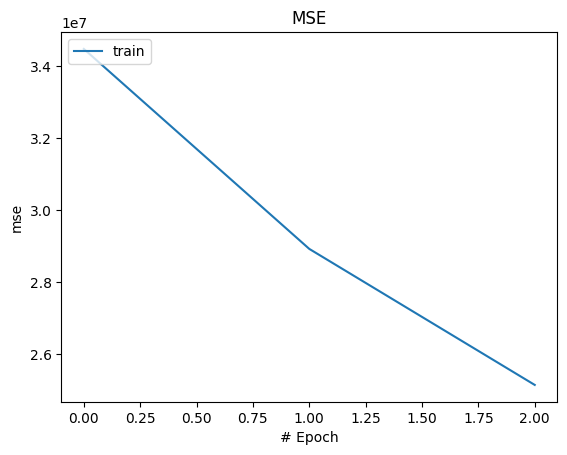

In [ ]:
plt.plot(history.history['mse'])
plt.title('MSE')
plt.ylabel('mse')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

3270/3270 [==============================] - 158s 48ms/step - loss: 23261866.0000 - mse: 23261866.0000
MSE: 23261866.0


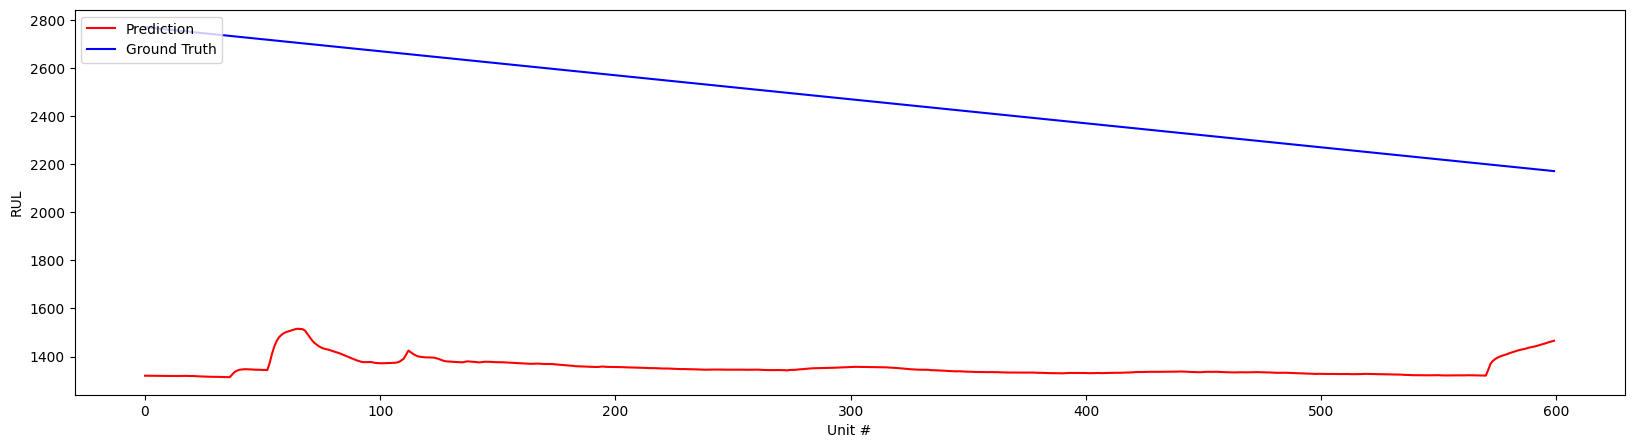

In [ ]:
y_pred_test = model.predict(X_train[0:2800], verbose=0)

plt.figure(figsize=(20, 5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_train[0:2800], color='blue', label='Ground Truth')
plt.ylabel('RUL')
plt.xlabel('Unit #')
plt.legend(loc='upper left')
plt.show()